In [1]:
import pandas as pd

In [2]:
df= pd.read_csv("Mall_Customers.csv")

In [3]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [9]:
df.columns

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')

# **Spark Session**

In [5]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=7e3b8337ffeff6ddb74667789a17fd6a7aa5f5a1e2056493c88a932321d3426a
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [18]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer, PCA

In [7]:
# Initialize Spark session
spark = SparkSession.builder.appName("KMeansClusteringExample").getOrCreate()

In [8]:
data_path = "Mall_Customers.csv"
data = spark.read.csv(data_path, header=True, inferSchema=True)

In [12]:
# Data preprocessing
# Convert categorical data to numeric
indexer = StringIndexer(inputCol="Gender", outputCol="GenderIndexed")
data = indexer.fit(data).transform(data)

In [13]:
# Assemble features into a single feature vector
assembler = VectorAssembler(
    inputCols=["Age", "Annual Income (k$)", "Spending Score (1-100)", "GenderIndexed"],
    outputCol="features")
data = assembler.transform(data)

In [14]:
# Train the K-means model
kmeans = KMeans().setK(5).setSeed(1)
model = kmeans.fit(data)

In [15]:
# Make predictions
predictions = model.transform(data)

In [16]:
# Evaluate clustering
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette with squared euclidean distance = {silhouette}")

Silhouette with squared euclidean distance = 0.6276007113904088


In [17]:
# Show cluster centers
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[24.96 28.04 77.    0.44]
[45.2173913  26.30434783 20.91304348  0.39130435]
[40.32432432 87.43243243 18.18918919  0.51351351]
[32.69230769 86.53846154 82.12820513  0.46153846]
[43.93421053 55.21052632 49.44736842  0.40789474]


In [19]:
pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pcaModel = pca.fit(predictions)
pcaResult = pcaModel.transform(predictions)

In [20]:
# Extracting components for plotting
result_df = pcaResult.select("pcaFeatures", "prediction").toPandas()
result_df['x'] = result_df['pcaFeatures'].apply(lambda x: x[0])
result_df['y'] = result_df['pcaFeatures'].apply(lambda x: x[1])

# **Visuals of clusters**

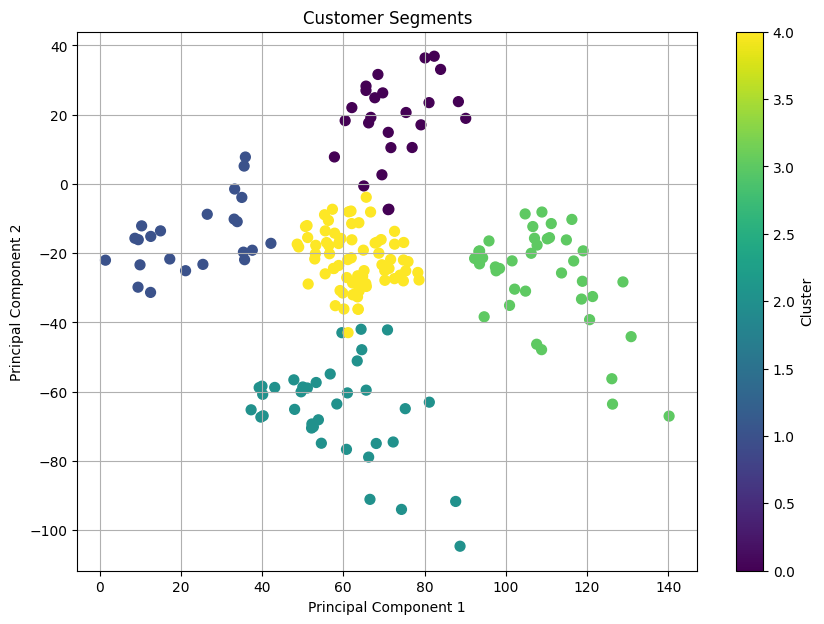

In [22]:
# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
scatter = plt.scatter(result_df['x'], result_df['y'], c=result_df['prediction'], cmap='viridis', s=50)
plt.title('Customer Segments')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

In [23]:
# Selecting the original data with the cluster assignments
clustered_data = predictions.select('CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'prediction')


In [24]:
# Group data by clusters and display
grouped_data = clustered_data.groupby('prediction').agg({'Age': 'mean', 'Annual Income (k$)': 'mean', 'Spending Score (1-100)': 'mean'}).sort('prediction')
print(grouped_data.show())

+----------+---------------------------+-----------------------+-----------------+
|prediction|avg(Spending Score (1-100))|avg(Annual Income (k$))|         avg(Age)|
+----------+---------------------------+-----------------------+-----------------+
|         0|                       77.0|                  28.04|            24.96|
|         1|          20.91304347826087|     26.304347826086957|45.21739130434783|
|         2|          18.18918918918919|      87.43243243243244|40.32432432432432|
|         3|          82.12820512820512|      86.53846153846153|32.69230769230769|
|         4|          49.44736842105263|      55.21052631578947|43.93421052631579|
+----------+---------------------------+-----------------------+-----------------+

None


# **Cluster-wise Data**

In [26]:
# Display details for each cluster
for i in range(5):
    print(f"\nCluster {i} details:")
    cluster_data = predictions.filter(predictions['prediction'] == i).select(
        'CustomerID', 'Gender', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)')
    cluster_data.show(truncate=False)


Cluster 0 details:
+----------+------+---+------------------+----------------------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|2         |Male  |21 |15                |81                    |
|4         |Female|23 |16                |77                    |
|6         |Female|22 |17                |76                    |
|8         |Female|23 |18                |94                    |
|10        |Female|30 |19                |72                    |
|12        |Female|35 |19                |99                    |
|14        |Female|24 |20                |77                    |
|16        |Male  |22 |20                |79                    |
|18        |Male  |20 |21                |66                    |
|20        |Female|35 |23                |98                    |
|22        |Male  |25 |24                |73                    |
|24        |Male  |31 |25                |73            